NOTE (what we need to do):
1. Copy all the coefficients generated by the linear regression model to the DataCollectorAlpha class
2. Find the sweetspot of the threshold, by looking at the y_pred distributions. So far we got 1165 if we set the threshold to 1.5, while we got 192 if the threshold is 5.

Optional future work:
1. Refactor map_engagement_value
2. Rework on the linear regression, doing parameter tuning and/or variable selection, etc.

# Imports

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple
from google.colab import drive

from sklearn.linear_model import LogisticRegression

In [ ]:
# mounting ggdrive regardless of who's running the code
from google.colab import drive
drive.mount('/content/drive')

# custom data paths - each person should add their own path to their documents folder if they want to use ggcolab :D
paths = {'jack': '/content/drive/MyDrive/recomsys assignment 2/',
         'ivan': '',
         'luqman': '/content/drive/MyDrive/recomsys assignment 2/',
         'ritesh': '',
         'max': '/content/drive/MyDrive/1_Fall 2023/2_MRS/assignment 2/sample_data/'
         }

# setting os chdir
import os
runner = input("Who's running the notebook? ")
os.chdir(paths[runner])
print("Drive mounted for %s!" %runner)

Mounted at /content/drive
Who's running the notebook? jack
Drive mounted for jack!


### HELPER FUNCTION: to create dummy value for one-hot's coefficient

In [ ]:
import random

def generate_numbers(n):
    numbers = [random.uniform(-1, 1) for _ in range(n - 1)]
    last_number = -sum(numbers)

    if -1 <= last_number <= 1:
        numbers.append(last_number)
        random.shuffle(numbers)
        return numbers
    else:
        return generate_numbers(n)


# DataCollector - Do Not Modify

In [ ]:
from sqlalchemy.sql.schema import ScalarElementColumnDefault
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

class DataCollector:
    def artist_styles_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def sources_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def num_inference_steps_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def one_hot_encoding_functions(self):
        return zip(
            [self.artist_styles_one_hot(), self.sources_one_hot(), self.num_inference_steps_one_hot()],
            ['artist_style', 'source', 'num_inference_steps']
        )

    def custom_aggregation(self, prefix, data):
        result = {
            f'{prefix}_likes': np.sum((data['engagement_type'] == 'Like') & (data['engagement_value'] == 1)),
            f'{prefix}_dislikes': np.sum((data['engagement_type'] == 'Like') & (data['engagement_value'] == -1)),
            f'{prefix}_engagement_time_avg': data[data['engagement_type'] == 'MillisecondsEngagedWith']['engagement_value'].mean(),
        }
        return pd.Series(result)

    def feature_generation_user(self):
        return self.user_data.groupby('user_id').apply(lambda data: self.custom_aggregation('user', data)).reset_index()

    def feature_generation_content_one_hot_encoding(self):
        for (categories, _coefficient), col_name in self.one_hot_encoding_functions():
            self.generated_content_metadata_data[col_name] = self.generated_content_metadata_data[col_name].apply(lambda x: x if x in categories else 'other')
            encoder = OneHotEncoder(categories=[categories + ['other']], sparse=False)
            encoded_data = encoder.fit_transform(self.generated_content_metadata_data[[col_name]])
            encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([col_name]))
            for col in encoded_df.columns:
              self.generated_content_metadata_data[col] = encoded_df[col]
        return self.generated_content_metadata_data

    def feature_generation_content_engagement_value(self):
        return self.engagement_data.groupby('content_id').apply(
            lambda data: self.custom_aggregation('content', data)
        ).reset_index()

    def feature_generation(self):
      self.feature_generation_user()
      self.feature_generation_content_one_hot_encoding()
      self.feature_generation_content_engagement_value()

    def get_engagement_data(self, content_ids):
      df = pd.read_csv('engagement.csv', sep="\t")
      return df[df['content_id'].isin(content_ids)]

    def get_generated_content_metadata_data(self, content_ids):
      df = pd.read_csv('generated_content_metadata.csv', sep="\t")
      return df[df['content_id'].isin(content_ids)]

    def get_user_data(self, user_id):
      df = pd.read_csv('engagement.csv', sep="\t")
      return df[df['user_id'] == user_id]

    def gather_data(self, user_id, content_ids):
      self.engagement_data = self.get_engagement_data(content_ids)
      self.generated_content_metadata_data = self.get_generated_content_metadata_data(content_ids)
      self.user_data = self.get_user_data(user_id)

    def gather_training_data(self):
      self.engagement_data = pd.read_csv('engagement.csv', sep="\t")
      self.generated_content_metadata_data = pd.read_csv('generated_content_metadata.csv', sep="\t")
      self.user_data = pd.read_csv('engagement.csv', sep="\t")

    def feature_eng_training(self):
      user_attr = self.feature_generation_user()
      content_engagement_features = self.feature_generation_content_engagement_value()
      generated_content_features = self.feature_generation_content_one_hot_encoding()

      interaction_pairs = self.engagement_data[
          ['user_id', 'content_id']].drop_duplicates()

      self.training_results = pd.merge(
          interaction_pairs,
          user_attr,
          on='user_id',
          how='left'
      ).fillna(0)

      content_results = pd.merge(
          generated_content_features,
          content_engagement_features,
          on='content_id',
          how='left'
      ).fillna(0)

      self.training_results = pd.merge(
          self.training_results,
          content_results,
          on='content_id',
          how='left'
      ).fillna(0)

      return self.training_results

    def feature_eng(self):
      user_attr = self.feature_generation_user()
      content_engagement_features = self.feature_generation_content_engagement_value()
      generated_content_features = self.feature_generation_content_one_hot_encoding()
      self.results = pd.merge(
          generated_content_features,
          content_engagement_features,
          on='content_id',
          how='left'
      ).fillna(0)
      self.results['user_id'] = user_attr['user_id'].iloc[0]
      self.results = pd.merge(
          self.results,
          user_attr,
          on='user_id'
      )

    def threshold(self):
        raise NotImplementedError("you need to implement")

    def coefficients(self):
        return {
            'content_likes': 0.0,
            'content_dislikes': 0.0,
            'content_engagement_time_avg': 0.0,

            'user_likes': 0.0,
            'user_dislikes': 0.0,
            'user_engagement_time_avg': 0.0,
        }

    def get_columns(self):
      cols = list(self.coefficients().keys())
      for (categories, _coefficients), col_name in self.one_hot_encoding_functions():
          for category, coefficient in zip(categories + ['other'], _coefficients):
            cols.append(col_name + "_" + str(category))
      return cols

    def run_linear_model(self):
        coeffs = self.coefficients()
        for (categories, _coefficients), col_name in self.one_hot_encoding_functions():
          for category, coefficient in zip(categories + ['other'], _coefficients):
            coeffs[col_name + "_" + str(category)] = coefficient

        self.results['linear_output'] = 0.0
        for col_name, _coefficient in coeffs.items():
            self.results['linear_output'] += self.results[col_name] * _coefficient
        return self.results[self.results['linear_output'] >= self.threshold()]['content_id'].values

    def filter_content_ids(self, user_id, content_ids):
      self.gather_data(user_id, content_ids)
      self.feature_eng()
      return self.run_linear_model()

# EDA

### Objective: to find out what the best variable combinations would be
### For Ivan, Max, Ritesh: place the EDA here. Jack did his initial EDA to get the grasp on what matter the most to the model

In [ ]:
# import generated content metadata
df_content = pd.read_csv('generated_content_metadata.csv', sep="\t")
df_engagement = pd.read_csv('engagement.csv', sep="\t")

Data Exploration:

In [ ]:
df_vote = df_engagement[df_engagement['engagement_type']!='MillisecondsEngagedWith']
top_content = df_vote.groupby(['content_id']).agg({'engagement_value': sum}).sort_values(by='engagement_value', ascending = False)
top_content.reset_index(inplace=True)

df_top_content = df_content[df_content['content_id'].isin(top_content['content_id'])]
df_top_content['rank'] = df_top_content['content_id'].apply(lambda x: np.where(top_content['content_id']==x))
df_top_content.sort_values(by='rank', inplace=True)

#Grouping all movie based iages together for the EDA
df_top_content['mod_artist_style'] = df_top_content['artist_style'].apply(lambda x: 'movie' if 'movie' in str(x) else x)
df_top_content['mod_source'] = df_top_content[['artist_style','source']].apply(lambda x: 'movie' if 'movie' in str(x['artist_style']) else x['source'], axis=1)

<ipython-input-8-2f1edbddb2b0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_content['rank'] = df_top_content['content_id'].apply(lambda x: np.where(top_content['content_id']==x))
<ipython-input-8-2f1edbddb2b0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_content.sort_values(by='rank', inplace=True)
<ipython-input-8-2f1edbddb2b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [ ]:
df_temp = pd.DataFrame(df_top_content['mod_artist_style'].head(1000).value_counts())
df_temp['total_count'] = 0
df_temp.reset_index(inplace=True)

for i, row in df_temp.iterrows():
  df_temp.at[i, 'total_count'] = df_content['content_id'][df_content['mod_artist_style']==row['index']].count()

df_temp = df_temp[df_temp['total_count']>100]

#Calculating the fraction of images in top 1000 against total population of each artist style in content df
df_temp['frac'] = df_temp['mod_artist_style']/df_temp['total_count']
df_temp.sort_values(by='frac', ascending = False, inplace=True)

top_10_artist_style = df_temp['index'].iloc[:10].values

df_temp2 = pd.DataFrame(df_top_content['mod_artist_style'].iloc[-1000:].value_counts())
df_temp2['total_count'] = 0
df_temp2.reset_index(inplace=True)

for i, row in df_temp2.iterrows():
  df_temp2.at[i, 'total_count'] = df_content['content_id'][df_content['mod_artist_style']==row['index']].count()

df_temp2 = df_temp2[df_temp2['total_count']>100]

#Calculating the fraction of images in bottom 1000 against total population of each artist style in content df
df_temp2['frac'] = df_temp2['mod_artist_style']/df_temp2['total_count']
df_temp2.sort_values(by='frac', ascending = False, inplace=True)

bottom_10_artist_style = df_temp2['index'].iloc[:10].values

print("Top 10 artist styles\n",top_10_artist_style)
print("Bottom 10 artist styles\n",bottom_10_artist_style)

KeyError: ignored

Shows how medieval, anime and studio are some of the top most like artist styles, while movies are way at the bottom (with only 105 appearances in the top 1000 images despite their overhwelming majority in the dataset)

In [ ]:
df_temp.head(10)

,index,mod_artist_style,total_count
0,movie,106,0
1,medieval,66,0
2,anime,37,0
3,studio,31,0
4,oil_on_canvas,21,0
5,unreal_engine,18,0
6,edward_hopper,17,0
7,ma_jir_bo,15,0
8,shepard_fairey,14,0
9,ibrahim_el_salahi,13,0


As seen below, movies make up ~800 of the bottom 1000 images. This makes up much of our motivation for the policy filters applied later in the notebook

In [ ]:
df_temp2.head(10)

NameError: ignored

array([[<Axes: title={'center': 'content_id'}>,
        <Axes: title={'center': 'guidance_scale'}>],
       [<Axes: title={'center': 'num_inference_steps'}>, <Axes: >]],
      dtype=object)

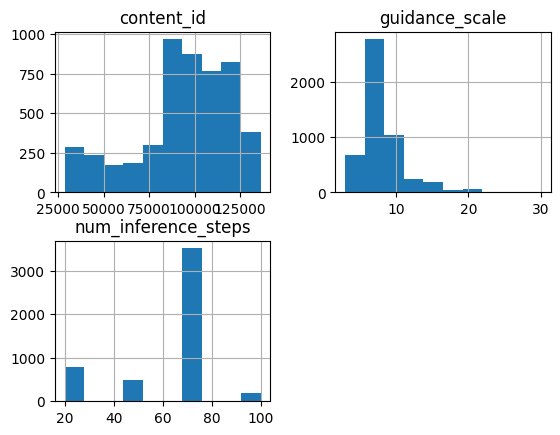

In [ ]:
#Numerical characteristics of top 5000 images
df_top_content.head(5000).hist()

array([[<Axes: title={'center': 'content_id'}>,
        <Axes: title={'center': 'guidance_scale'}>],
       [<Axes: title={'center': 'num_inference_steps'}>, <Axes: >]],
      dtype=object)

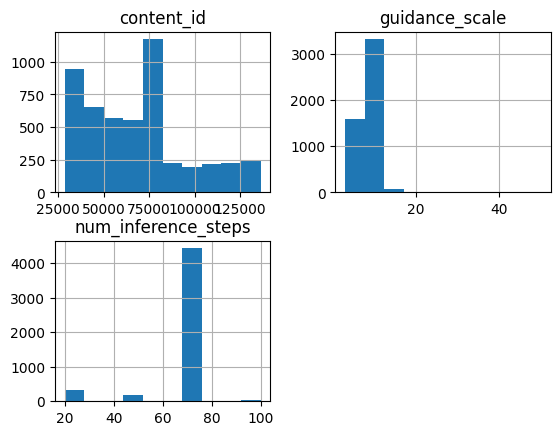

In [ ]:
#Numerical characteristics of bottom 5000 images
df_top_content.tail(5000).hist()

### Investigate artist_style

In [ ]:
df_artist_style = df_content['artist_style'].value_counts()
df_artist_style

van_gogh                                      1097
jean-michel_basquiat                          1083
detailed_portrait                             1073
kerry_james_marshall                          1042
medieval                                      1040
                                              ... 
movie: The-Corruptor                             1
movie: Scandal-Early-Pilot-1-TV-Script-PDF       1
movie: Star-Wars-Attack-of-the-Clones            1
movie: 2001-A-Space-Odyssey                      1
movie: Room-The                                  1
Name: artist_style, Length: 1429, dtype: int64

In [ ]:
# We set the cut off would be "juan_gris"
df_artist_style[df_artist_style > 100]

van_gogh                                            1097
jean-michel_basquiat                                1083
detailed_portrait                                   1073
kerry_james_marshall                                1042
medieval                                            1040
studio                                              1019
edward_hopper                                       1008
takashi_murakami                                    1001
anime                                                998
leonardo_da_vinci                                    995
laura_wheeler_waring                                 993
ma_jir_bo                                            987
jackson_pollock                                      985
shepard_fairey                                       973
unreal_engine                                        968
face_and_lighting                                    963
keith_haring                                         962
marta_minujín                  

In [ ]:
# Setting the cut-off to Juan Gris
df_artist_style[df_artist_style > 500].index

Index(['van_gogh', 'jean-michel_basquiat', 'detailed_portrait',
       'kerry_james_marshall', 'medieval', 'studio', 'edward_hopper',
       'takashi_murakami', 'anime', 'leonardo_da_vinci',
       'laura_wheeler_waring', 'ma_jir_bo', 'jackson_pollock',
       'shepard_fairey', 'unreal_engine', 'face_and_lighting', 'keith_haring',
       'marta_minujín', 'franck_slama', 'oil_on_canvas', 'scifi', 'gta_v',
       'louise bourgeois', 'salvador_dali', 'ibrahim_el_salahi', 'juan_gris'],
      dtype='object')

### Investigate Source

In [ ]:
df_source = df_content['source'].value_counts()
df_source

human_prompts                                                          26179
r/Showerthoughts                                                        4419
r/EarthPorn                                                             2159
r/scifi                                                                 1792
r/pics                                                                  1534
                                                                       ...  
Dr-Strangelove                                                             1
Flower God, God Of The Spring by Robert Louis Stevenson                    1
Star-Wars-IV-A-New-Hope                                                    1
Finding-Nemo                                                               1
Fragment: 'I Faint, I Perish With My Love!' by Percy Bysshe Shelley        1
Name: source, Length: 3845, dtype: int64

In [ ]:
# We set the cut off would be "r/SimplePrompts"
df_source[df_source > 500]

human_prompts             26179
r/Showerthoughts           4419
r/EarthPorn                2159
r/scifi                    1792
r/pics                     1534
r/Damnthatsinteresting     1206
r/MadeMeSmile              1125
r/educationalgifs           958
r/SimplePrompts             778
Name: source, dtype: int64

In [ ]:
df_source[df_source > 500].index

Index(['human_prompts', 'r/Showerthoughts', 'r/EarthPorn', 'r/scifi', 'r/pics',
       'r/Damnthatsinteresting', 'r/MadeMeSmile', 'r/educationalgifs',
       'r/SimplePrompts'],
      dtype='object')

### Investigate num_inference_steps

In [ ]:
# Ideally we will pick 75, but every time we went with it, it returned error. we think that there were bugs, so we picked 100 as a baseline for now
df_inference_steps = df_content['num_inference_steps'].value_counts()
df_inference_steps

75     82004
20     14476
50      8411
100     2814
Name: num_inference_steps, dtype: int64

# Working Process -- not for submission
### Please refer to the cell [FOR SUBMISSION] at the bottom of this notebook

In [ ]:
# To generate coeficients, fill with dummy numbers now.
class DataCollectorAlpha(DataCollector): #Changed the class name here, might need to adjust based on the convention
  def artist_styles_one_hot(self):
    return [
        'van_gogh', 'jean-michel_basquiat', 'detailed_portrait',
       'kerry_james_marshall', 'medieval', 'studio', 'edward_hopper',
       'takashi_murakami', 'anime', 'leonardo_da_vinci',
       'laura_wheeler_waring', 'ma_jir_bo', 'jackson_pollock',
       'shepard_fairey', 'unreal_engine', 'face_and_lighting', 'keith_haring',
       'marta_minujín', 'franck_slama', 'oil_on_canvas', 'scifi', 'gta_v',
       'louise bourgeois', 'salvador_dali', 'ibrahim_el_salahi', 'juan_gris'
    ],  generate_numbers(26)
  def sources_one_hot(self):
    return [
        'human_prompts', 'r/Showerthoughts', 'r/EarthPorn', 'r/scifi', 'r/pics',
       'r/Damnthatsinteresting', 'r/MadeMeSmile', 'r/educationalgifs',
       'r/SimplePrompts'
    ],  generate_numbers(9)

  def num_inference_steps_one_hot(self):
    return [
        100
    ], [
        0.535, -0.535
    ]

  def one_hot_encoding_functions(self):
    return zip(
        [self.artist_styles_one_hot(), self.sources_one_hot(), self.num_inference_steps_one_hot()],
        ['artist_style', 'source', 'num_inference_steps']
    )

  def threshold(self):
    return 1.5 #NOTE to alpha team. setting 1.5 yields 1165 filtered contents; while 5 yields 192

  def coefficients(self):
        return {
            'content_likes': 0.411,
            'content_dislikes': -1.25,
            'content_engagement_time_avg': -7.0458305856391235e-09,

            'user_likes': 0.00327,
            'user_dislikes': -0.0029,
            'user_engagement_time_avg': 1.6684465996563702e-06,
        }

# Working Process -- not for submission
### Please refer to the cell [FOR SUBMISSION] at the bottom of this notebook

In [ ]:
data_collector = DataCollectorAlpha()
random_content_ids = pd.read_csv('generated_content_metadata.csv', sep="\t")['content_id'].values
filtered_contents = data_collector.filter_content_ids(1, random_content_ids)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Training

In [ ]:
#@title get training data
data_collector = DataCollectorAlpha()
data_collector.gather_training_data()
training_data = data_collector.feature_eng_training()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#@title code to implement
def get_Y(engagement_data: pd.DataFrame) -> pd.DataFrame:
    """Engineers taget variable.
    Args
      data (pd.DataFrame): Engagement data.
    Returns
      pd.DataFrame: Dataframe of 3 columns; 'user_id', 'content_id', 'score',
        where 'score' being the target variable that you want to predict.
    """
    # Dummy target dataframe. Your output dataframe should have 3 columns; 'user_id', 'content_id', 'score'
    # Where 'score' being the target variable that you want to predict.

    def map_engagement_value(row, min, max):
        if str(row['engagement_type']) == 'Like':
            return row['engagement_value'] * 10
        elif str(row['engagement_type']) == 'MillisecondsEngagedWith':
            return (row['engagement_value'] - min) / (max-min)
        else:
            return None  # Handle other cases if needed

    engagement_time = engagement_data.loc[engagement_data['engagement_type'] == 'MillisecondsEngagedWith',['engagement_value']]
    max = engagement_time.max()
    min = engagement_time.min()

    engagement_data["engagement_value"] = engagement_data.apply(map_engagement_value, args=(min,max), axis=1)

    target_df = engagement_data.groupby(
        ['user_id', 'content_id']
        )['engagement_value'].sum().rename('score',
                                           inplace=True
                                           ).to_frame().reset_index()

    # DO NOT CHANGE THIS. This step ensures that each row of the target variable (X)
    # corresponds to the correct row of features (y).
    target_df = pd.merge(
          training_data[['user_id', 'content_id']],
          target_df,
          on=['user_id', 'content_id'],
          how='left'
      )

    return target_df['score']

engagement_data = pd.read_csv('engagement.csv', sep="\t")
X = training_data[data_collector.get_columns()]
y = get_Y(engagement_data)

In [ ]:
y

0         0.000005
1         0.000004
2         0.000007
3         0.000007
4         0.000003
            ...   
161523   -9.999978
161524    0.000007
161525   -9.999994
161526   -9.999993
161527    0.000005
Name: score, Length: 161528, dtype: float64

In [ ]:
# training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Split data into train and test: Add/change  other parametersas you wish
# Also, feel free to use cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Depending on what your target variable y looks like, you have to choose a suitable model.
# Here, I assume y is binary, and so I use Logistic Regression.
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

print(f"MSE: {np.mean((y_pred - y_test)**2)}")

MSE: 37.93488495644865


(array([7.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 8.000e+00, 4.000e+00,
        1.000e+01, 2.000e+00, 7.000e+00, 9.000e+00, 1.100e+01, 1.500e+01,
        3.200e+01, 6.600e+01, 9.900e+01, 1.500e+02, 1.670e+02, 5.270e+02,
        4.050e+02, 6.340e+02, 8.720e+02, 1.700e+03, 3.110e+03, 4.548e+03,
        5.849e+03, 5.773e+03, 5.455e+03, 3.926e+03, 2.183e+03, 1.214e+03,
        9.990e+02, 6.860e+02, 6.930e+02, 4.510e+02, 2.810e+02, 1.590e+02,
        1.170e+02, 4.800e+01, 4.000e+01, 2.900e+01, 2.000e+01, 2.100e+01,
        1.800e+01, 1.000e+01, 9.000e+00, 5.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-22.80076167, -21.88257548, -20.96438929, -20.0462031 ,
        -19.12801692, -18.20983073, -17.29164454, -16.37345836,
        -15.45527217, -14.53708598, -13.61889979, -12.70071361,
        -11.78252742, -10.86434123,  -9.94615504,  -9.02796886,
         -8.10978267,  -7.19159648,  -6.27341029,  -5.35522411,
         -4.43703792,  -3.51885173,  -2.60066555,  -1.68

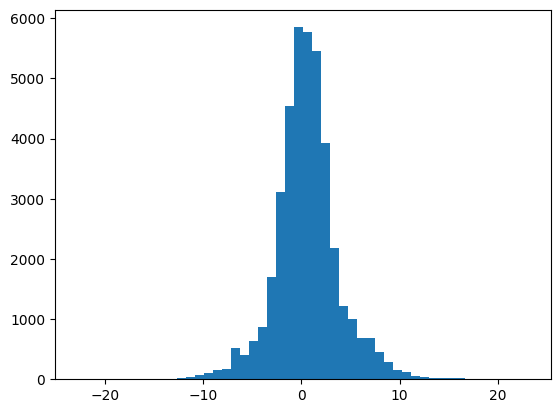

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_pred, bins=50)

# What You Need

In [ ]:
print("{")
for x, y in zip(model.feature_names_in_, model.coef_):
  print(f"\t{x}: {y},")
print("}")

{
	content_likes: 0.3729444814634858,
	content_dislikes: -1.2006654135645038,
	content_engagement_time_avg: 6.382389318662367e-09,
	user_likes: 0.003268094706322221,
	user_dislikes: -0.002904938856053222,
	user_engagement_time_avg: 1.6472635150993565e-06,
	artist_style_van_gogh: 1.8829634304994178,
	artist_style_jean-michel_basquiat: 0.5457368617758162,
	artist_style_detailed_portrait: 1.6577201929375593,
	artist_style_kerry_james_marshall: 0.9504379110010311,
	artist_style_medieval: 2.056287976702721,
	artist_style_studio: 2.3627076827786513,
	artist_style_edward_hopper: 1.835396488525314,
	artist_style_takashi_murakami: 0.8737074989081304,
	artist_style_anime: 1.882053853127063,
	artist_style_leonardo_da_vinci: 0.5535647061281743,
	artist_style_laura_wheeler_waring: 0.565895886618904,
	artist_style_ma_jir_bo: 0.9564286285466588,
	artist_style_jackson_pollock: 0.7469320775758425,
	artist_style_shepard_fairey: 1.6988407208303953,
	artist_style_unreal_engine: 1.2276789400670531,
	artist

In [ ]:
model.coef_

array([ 3.74916080e-01, -1.21678152e+00, -1.45926026e-09,  3.29418059e-03,
       -2.89415721e-03,  1.65798069e-06,  1.80839659e+00,  4.57661357e-01,
        1.52902015e+00,  7.13037728e-01,  2.12601976e+00,  2.31831502e+00,
        1.60836141e+00,  6.35208261e-01,  1.93407169e+00,  8.62543569e-01,
        3.87092828e-01,  8.58692225e-01,  8.16427795e-01,  1.80168642e+00,
        1.18986743e+00,  6.47276517e-01,  1.45798984e+00,  1.40309039e+00,
        1.08035306e-01,  1.91956838e+00,  1.98582217e+00,  7.04217187e-01,
        8.69372489e-01,  1.06634192e+00,  1.60554420e+00,  1.97965241e+00,
        1.78835700e+00, -3.36104874e-01,  7.83608333e-01, -1.22464380e-01,
       -8.97086012e-01, -6.80186950e-01, -1.04964657e+00, -2.46420655e-01,
        3.54237602e-01,  1.85527639e-01, -1.85527638e-01])

# [FOR SUBMISSION]

### Workflow: Linear Regression based filtering -> Two hard-coded policy filtering

## Linear Regression Based Filtering

In [ ]:
# Update coef_.
class DataCollectorAlpha(DataCollector): #Changed the class name here, might need to adjust based on the convention
  def artist_styles_one_hot(self):
    return [
        'van_gogh', 'jean-michel_basquiat', 'detailed_portrait',
       'kerry_james_marshall', 'medieval', 'studio', 'edward_hopper',
       'takashi_murakami', 'anime', 'leonardo_da_vinci',
       'laura_wheeler_waring', 'ma_jir_bo', 'jackson_pollock',
       'shepard_fairey', 'unreal_engine', 'face_and_lighting', 'keith_haring',
       'marta_minujín', 'franck_slama', 'oil_on_canvas', 'scifi', 'gta_v',
       'louise bourgeois', 'salvador_dali', 'ibrahim_el_salahi', 'juan_gris'
    ],  [1.83523859e+00,  2.77885424e-01,
        1.70090565e+00,  9.49429353e-01,  2.15906078e+00,  2.44568696e+00,
        1.79434951e+00,  9.07959350e-01,  2.17337238e+00,  4.60592065e-01,
        4.09057593e-01,  8.42021422e-01,  6.68317933e-01,  1.76814775e+00,
        1.41639637e+00,  6.58195898e-01,  1.50787499e+00,  1.21004481e+00,
        3.05043625e-01,  1.94261633e+00,  1.96512518e+00,  9.10388431e-01,
        9.15045962e-01,  1.31553474e+00,  1.54801667e+00,  1.90712583e+00, 0]
  def sources_one_hot(self):
    return [
        'human_prompts', 'r/Showerthoughts', 'r/EarthPorn', 'r/scifi', 'r/pics',
       'r/Damnthatsinteresting', 'r/MadeMeSmile', 'r/educationalgifs',
       'r/SimplePrompts'
    ],  [ 1.78062418e+00, -4.38372622e-01,  7.01822304e-01, -7.25890558e-02,
       -6.61610991e-01, -8.99656743e-01, -1.01408713e+00, -1.54566954e-01,
        2.05666798e-01, -0.5527702]

  def num_inference_steps_one_hot(self):
    return [
        100
    ], [
        0.535, -0.535
    ]

  def one_hot_encoding_functions(self):
    return zip(
        [self.artist_styles_one_hot(), self.sources_one_hot(), self.num_inference_steps_one_hot()],
        ['artist_style', 'source', 'num_inference_steps']
    )

  def threshold(self):
    return 0.001 #NOTE to alpha team. setting 1.5 yields 1165 filtered contents; while 6 yields 251

  def coefficients(self):
        return {
            'content_likes': 0.411,
            'content_dislikes': -1.25,
            'content_engagement_time_avg': -7.0458305856391235e-09,

            'user_likes': 0.00327,
            'user_dislikes': -0.0029,
            'user_engagement_time_avg': 1.6684465996563702e-06,
        }

In [ ]:
data_collector = DataCollectorAlpha()
random_content_ids = random.sample(list(training_data.content_id.unique()), 1500)
filtered_contents = data_collector.filter_content_ids(1, random_content_ids)
len(filtered_contents)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


872

# Policy Filtering 1

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def policy_filter_one(training_data, content_id):
  """
  Filtering on Likes: only keeping images with a 'decent' number of likes (or over a small negative number, say -1)
  """
  try:
    if training_data[training_data.content_id == content_id].content_engagement_time_avg.mean() > 1e3:
      # making sure people saw the img, say at least 1s
      like_value = training_data[training_data.content_id == content_id].content_likes.iloc[0]
      dislike_value = training_data[training_data.content_id == content_id].content_dislikes.iloc[0]
      diff = like_value - dislike_value
      #only keep first line since we only care about the nb of likes
      if diff > 0:
        return True
      return False
    else:
      return True
  except:
    # if no like value, that means
    return True

policy_filter_one(
    training_data[training_data['content_id'] == random_content_ids[0]],
    random_content_ids[0]
)

True

In [ ]:
# checking nb of candidates after filtering
s_l = []
for i in tqdm(range(10)):
  s_l.append(
    sum([policy_filter_one(training_data, content_id) for content_id in random.sample(list(training_data.content_id.unique()), 1500)])
  )
s_l

  0%|          | 0/10 [00:00<?, ?it/s]

[747, 734, 763, 766, 760, 746, 730, 760, 746, 747]

# Policy Filtering 2

In [ ]:
import random

In [ ]:
def policy_filter_two(training_data, content_id):
  """ Checking if source is from the 'other' category;
  most of the movies pictures being in this category, we will return this type of image only x% of the time.
  The random package MUST be imported"""
  try:
    source = training_data[training_data.content_id == content_id].source.iloc[0]
    if source == 'other':
      random_number = random.random()

      # threshold for selection
      threshold = 0.90

      # Check if the random number is less than the probability threshold
      if random_number < threshold:
        return True
    return False
  except:
    return False

policy_filter_two(
    training_data[training_data['content_id'] == random_content_ids[0]],
    random_content_ids[0]
)

True

In [ ]:
s_l = []
for i in tqdm(range(10)):
  s_l.append(
    sum([policy_filter_two(training_data, content_id) for content_id in random.sample(list(training_data.content_id.unique()), 1500)])
  )
s_l

  0%|          | 0/10 [00:00<?, ?it/s]

[826, 824, 838, 820, 822, 806, 826, 806, 857, 805]

In [ ]:
# Combining two policies
s_two_policies = []
for i in tqdm(range(10)):
  sample = random.sample(list(training_data.content_id.unique()), 1500)
  s_two_policies.append(
    sum([policy_filter_two(training_data, content_id) for content_id in sample if policy_filter_one(training_data, content_id)])
  )
s_two_policies


  0%|          | 0/10 [00:00<?, ?it/s]

[369, 383, 393, 362, 373, 319, 333, 375, 351, 394]

In [ ]:
# Combining two policies after filtered contents from regression
s_two_policies = []
for i in tqdm(range(10)):
  random_content_ids = random.sample(list(training_data.content_id.unique()), 1500)
  filtered_contents = data_collector.filter_content_ids(1, random_content_ids)
  s_two_policies.append(
    sum([policy_filter_two(training_data, content_id) for content_id in filtered_contents if policy_filter_one(training_data, content_id)])
  )
s_two_policies

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

[292, 298, 277, 282, 255, 279, 277, 278, 276, 252]